In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)

import gensim
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils, callbacks

from utils import *

data = load_csv()

NUM_OF_CLASSES = len(data['flair'].unique())
data.head()

,url,title,body,comments,descriptor,flair
id,,,,,,
g1zi21,https://www.reddit.com/r/india/comments/g1zi21...,Coronavirus (COVID-19) Megathread - News and U...,###[Covid-19 Fundraisers & Donation Links](htt...,###[Covid-19 Fundraisers & Donation Links](ht...,Coronavirus (COVID-19) Megathread - News and U...,Coronavirus
g4d2ix,https://www.reddit.com/r/india/comments/g4d2ix...,"[Monthly Happiness Thread] Randians, please sh...",<3 \n \nLinks: ...,Working from home since past one month. For s...,"[Monthly Happiness Thread] Randians, please sh...",Other
g79auq,https://i.redd.it/5b2bepewzru41.jpg,Greetings from Saudi Arabia. During this lock ...,,"Not much of a expert in this, but looks good!...",Greetings from Saudi Arabia. During this lock ...,Other
g7b3un,https://www.reddit.com/r/india/comments/g7b3un...,Covid19 hit me. I just got fired.,Just one call. We are having trouble with mone...,If you were doing good for yourself it wont b...,Covid19 hit me. I just got fired. Just one cal...,Coronavirus
g77k1z,https://www.ndtv.com/india-news/coronavirus-pm...,PM CARES fund won’t be checked by government’s...,,No transparency at all from a government whic...,PM CARES fund won’t be checked by government’s...,Politics


In [2]:
processed = preprocess_docs(data['descriptor'])
print('Before processsing: ', processed[0][:8])
print('After processsing: ', data['descriptor'][0][:80])

Before processsing:  ['coronavirus', 'covid', 'megathread', 'news', 'and', 'updates', 'covid', 'fundraisers']
After processsing:  Coronavirus (COVID-19) Megathread - News and Updates - 4 ###[Covid-19 Fundraiser


In [3]:
corpus = [TaggedDocument(tokens, [i]) for (i, tokens) in enumerate(processed)]

embedding_model = Doc2Vec(
    corpus,
    vector_size=EMBEDDING_SIZE,
    min_count=1,
    workers=4
)

embedding_model.train(corpus, total_examples=len(corpus), epochs=100)
embedding_model.save('models/embedding_model.pkl')

embeddings = docs_into_vectors(processed, embedding_model)
print(embeddings.shape)

(2018, 150)


In [4]:
labels = data['flair']

le = LabelEncoder()
le.fit(labels)
labels = le.transform(labels)

labels = utils.to_categorical(labels)
labels.shape

with open('models/le.pkl', 'wb') as handle:
    pickle.dump(le, handle)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, labels,
    test_size=0.2,
    stratify=labels,
    random_state=7
)

In [6]:
model = Sequential()
model.add(Dense(32, input_dim=EMBEDDING_SIZE, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(NUM_OF_CLASSES, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=(1e-3)), metrics=['accuracy'])

In [7]:
checkpoint = callbacks.ModelCheckpoint(
    'models/classification_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1,
    save_freq='epoch'
)

es = callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    patience=10
)

In [8]:
hist = model.fit(
    X_train, y_train,
    epochs=50,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint, es]
)

Train on 1614 samples, validate on 404 samples
Epoch 1/50
1504/1614 [==========================>...] - ETA: 0s - loss: 2.0022 - accuracy: 0.2254
Epoch 00001: val_accuracy improved from -inf to 0.34653, saving model to models/classification_model.h5
1614/1614 [==============================] - 2s 1ms/sample - loss: 1.9918 - accuracy: 0.2317 - val_loss: 1.8320 - val_accuracy: 0.3465
Epoch 2/50
1568/1614 [============================>.] - ETA: 0s - loss: 1.8186 - accuracy: 0.3469
Epoch 00002: val_accuracy improved from 0.34653 to 0.51980, saving model to models/classification_model.h5
1614/1614 [==============================] - 1s 337us/sample - loss: 1.8222 - accuracy: 0.3463 - val_loss: 1.6672 - val_accuracy: 0.5198
Epoch 3/50
1536/1614 [===========================>..] - ETA: 0s - loss: 1.7061 - accuracy: 0.4082
Epoch 00003: val_accuracy did not improve from 0.51980
1614/1614 [==============================] - 1s 331us/sample - loss: 1.7020 - accuracy: 0.4102 - val_loss: 1.5238 - val_a

1536/1614 [===========================>..] - ETA: 0s - loss: 1.2144 - accuracy: 0.5866
Epoch 00027: val_accuracy did not improve from 0.61386
1614/1614 [==============================] - 0s 301us/sample - loss: 1.2101 - accuracy: 0.5880 - val_loss: 1.2090 - val_accuracy: 0.6089
Epoch 28/50
1600/1614 [============================>.] - ETA: 0s - loss: 1.1672 - accuracy: 0.6000
Epoch 00028: val_accuracy did not improve from 0.61386
1614/1614 [==============================] - 0s 292us/sample - loss: 1.1652 - accuracy: 0.6010 - val_loss: 1.2110 - val_accuracy: 0.5916
Epoch 29/50
1568/1614 [============================>.] - ETA: 0s - loss: 1.1771 - accuracy: 0.6052
Epoch 00029: val_accuracy did not improve from 0.61386
1614/1614 [==============================] - 0s 294us/sample - loss: 1.1754 - accuracy: 0.6059 - val_loss: 1.2081 - val_accuracy: 0.5990
Epoch 30/50
1568/1614 [============================>.] - ETA: 0s - loss: 1.1727 - accuracy: 0.5765
Epoch 00030: val_accuracy did not improv

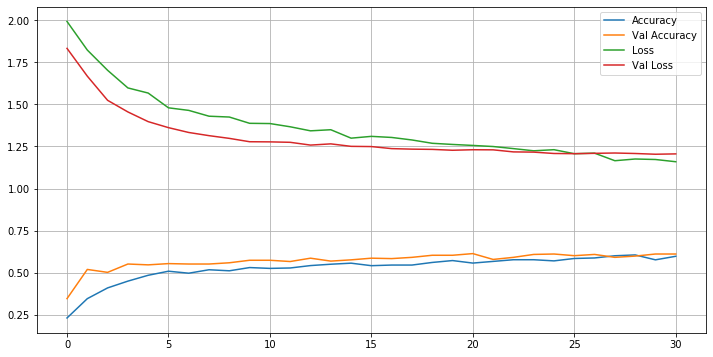

In [9]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Accuracy', 'Val Accuracy', 'Loss', 'Val Loss'])
plt.grid(True)

In [10]:
# Sanity check

model = keras.models.load_model('models/classification_model.h5')
print(model.evaluate(X_test, y_test, verbose=0))

embedding_model = gensim.models.Doc2Vec.load('models/embedding_model.pkl')
sample_doc = ['hi', 'i', 'am', 'vasu'] # Includes out-of-vocab words
print(doc_into_vector(sample_doc, embedding_model).shape[0] == EMBEDDING_SIZE)

[1.2303904023500953, 0.6138614]
True
